## Introduction

### Build a Machine Learning model to predict the CTR(click through rate) of an email campaign based on the email campaigning information.

### Import the necessary packages.

In [4]:
!pip install scikit-learn==0.23.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 8.6 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.2 which is incompatible.
mlxtend 0.20.0 requires scikit-learn>=1.0.2, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 0.23.2 which is incompatible.
hypertools 0.8.0 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
gplearn 0.4.2 requires scikit-learn>=1.0.2, but you

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

### Import train and test dataset

In [143]:
train=pd.read_csv("../input/jobathon-august-2022/train_F3fUq2S.csv")
test=pd.read_csv("../input/jobathon-august-2022/test_Bk2wfZ3.csv")

### Pre-processing function


In [112]:
def pre_process(df):
    #New feature
    df['user_count']=(df.groupby(['sender','category','product'])['campaign_id'].transform('count'))


    #Category columns 
    grpcol=['sender','day_of_week','is_weekend','times_of_day',
           'category','product','is_image','is_personalised',
           'is_quote','is_emoticons','is_discount',
           'is_price','is_urgency']
    
    #numerical columns
    numcol=['subject_len','body_len','mean_paragraph_len','no_of_CTA','mean_CTA_len']
    
    #convert the price column to binary column
    df['is_price']=(df['is_price']>0).astype('int')
    
    #define label encoder
    lbl_encode=LabelEncoder()
    
    #apply label encoder to times_of_day column
    df['times_of_day']=lbl_encode.fit_transform(df[['times_of_day']])
    
    #Function for numerical feature engineering
    def num_feature_eng(df):
        
        for i in numcol:
            df1=(df.groupby(grpcol)[i].agg({'min','median','max','mean'}).reset_index())


            df1=(df1.rename(columns={col:'grp_'+i+'_'+col for col in df1.loc[:,df1.columns.str.
                            match("(min|median|max|mean)")]}))
            df=pd.merge(df,df1,on=grpcol,how='left')

        return df

    #Apply the numerical feature engineering for products_purchased column
    df=num_feature_eng(df) 

    #New feature    
    df['body_len_grt_para_len']=(df['body_len']>df['mean_paragraph_len']).astype('int')


    return df

### Apply the pre-processing steps to train dataset

In [144]:
train=pre_process(train)

### Import pycaret model

In [15]:
!pip install imbalanced-learn==0.7.0
!pip install --user pycaret[full] -q
!pip install numba==0.53 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 769.0 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.9.0
    Uninstalling imbalanced-learn-0.9.0:
      Successfully uninstalled imbalanced-learn-0.9.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this

In [16]:
import pycaret

In [17]:
from pycaret.regression import *

In [165]:
for i,j in enumerate(train.columns.values):
    print(f"{i}_{j}")

0_campaign_id
1_sender
2_subject_len
3_body_len
4_mean_paragraph_len
5_day_of_week
6_is_weekend
7_times_of_day
8_category
9_product
10_no_of_CTA
11_mean_CTA_len
12_is_image
13_is_personalised
14_is_quote
15_is_timer
16_is_emoticons
17_is_discount
18_is_price
19_is_urgency
20_target_audience
21_click_rate
22_user_count
23_grp_subject_len_mean
24_grp_subject_len_max
25_grp_subject_len_median
26_grp_subject_len_min
27_grp_body_len_mean
28_grp_body_len_max
29_grp_body_len_median
30_grp_body_len_min
31_grp_mean_paragraph_len_mean
32_grp_mean_paragraph_len_max
33_grp_mean_paragraph_len_median
34_grp_mean_paragraph_len_min
35_grp_no_of_CTA_mean
36_grp_no_of_CTA_max
37_grp_no_of_CTA_median
38_grp_no_of_CTA_min
39_grp_mean_CTA_len_mean
40_grp_mean_CTA_len_max
41_grp_mean_CTA_len_median
42_grp_mean_CTA_len_min
43_body_len_grt_para_len


### Split predictor(X) and response(y) variable

In [116]:
X=train.iloc[:,np.r_[1:15,16:21,22:44]]
y=train['click_rate']

### Create a new dataframe with concatenate the selected predictor and response variable.

In [117]:
train1=pd.concat([X,y],axis=1)

### Setup model to train

In [130]:
clf_pycaret = setup(data = train1,
                    data_split_shuffle=True,
                    fold_strategy="kfold",
                    fold_shuffle=True,
                    fold=5,
                    target = 'click_rate', session_id=112,
                    use_gpu =True,
                    silent=True
                   ) 
set_config('seed', 123)

,Description,Value
0,session_id,112
1,Target,click_rate
2,Original Data,"(1888, 42)"
3,Missing Values,False
4,Numeric Features,27
5,Categorical Features,14
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1321, 106)"


### Compare more than one regressor models and then select the top 3 models based on the r2 score.

In [131]:
top3 = compare_models(sort = 'R2',n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0307,0.0039,0.0614,0.4253,0.0509,2.1820,3.6740
lightgbm,Light Gradient Boosting Machine,0.0333,0.0040,0.0628,0.3976,0.0520,2.3685,0.4340
gbr,Gradient Boosting Regressor,0.0326,0.0041,0.0634,0.3800,0.0527,2.3611,0.6000
rf,Random Forest Regressor,0.0332,0.0043,0.0648,0.3612,0.0539,2.6557,1.4860
et,Extra Trees Regressor,0.0315,0.0043,0.0648,0.3590,0.0539,2.3666,2.1240
xgboost,Extreme Gradient Boosting,0.0335,0.0043,0.0651,0.3515,0.0544,2.6346,0.5000
omp,Orthogonal Matching Pursuit,0.0433,0.0059,0.0767,0.0994,0.0638,3.9964,0.0160
br,Bayesian Ridge,0.0452,0.0063,0.0787,0.0528,0.0658,4.5113,0.0360
knn,K Neighbors Regressor,0.0423,0.0062,0.0785,0.0454,0.0667,3.8856,0.2140
lasso,Lasso Regression,0.0461,0.0063,0.0789,0.0450,0.0662,4.7002,0.1900


### Blend the top 3 model

In [134]:
blender = blend_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0294,0.0040,0.0629,0.3500,0.0517,1.9386
1,0.0348,0.0041,0.0639,0.4869,0.0530,2.2027
2,0.0356,0.0045,0.0672,0.3483,0.0558,2.5370
3,0.0247,0.0020,0.0448,0.5016,0.0392,1.6793
4,0.0302,0.0044,0.0660,0.4713,0.0529,2.5871
Mean,0.0309,0.0038,0.0610,0.4316,0.0505,2.1889
Std,0.0040,0.0009,0.0082,0.0680,0.0058,0.3470


### Finalize the belnded model

In [135]:
final = finalize_model(blender)

In [45]:
from sklearn import set_config
set_config(display="diagram")

In [136]:
final

VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f94181c3850>),
                            ('lightgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0, device='gpu',
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leave...
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_iter_no_change=None,
                                                       presort='deprecated',
                                                       random_state=112,
                                                       subsample=1.0,
                                                       tol=0.0001,
                                                       validation_fraction=0.1,
                                                       verbose=0,
                                                       warm_start=False))],
                n_jobs=1, verbose=False, weights=None)

### Model Residual Plot

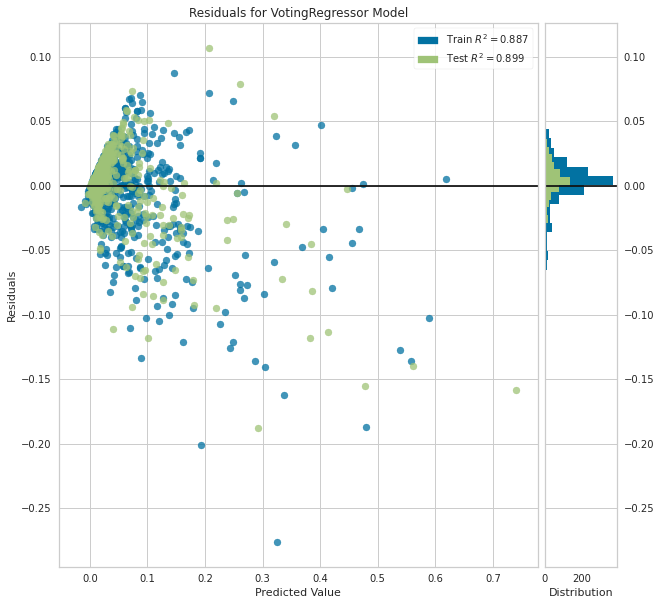

In [152]:
plt.figure(figsize = (10,10))
plot_model(final, plot = 'residuals')

### Error plot

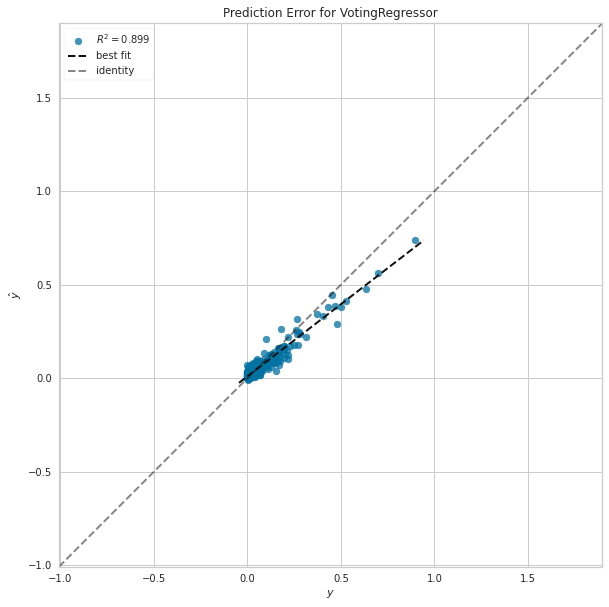

In [153]:
plt.figure(figsize = (10,10))
plot_model(final, plot = 'error')

### Catboost model feature importance plot

<Figure size 720x720 with 0 Axes>

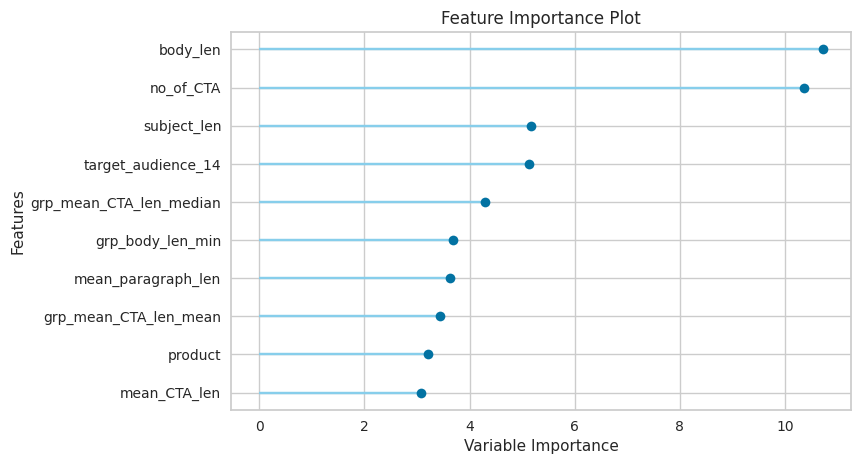

In [158]:
plt.figure(figsize = (10,10));
plot_model(final.named_estimators_[list(final.named_estimators)[0]], plot = 'feature');

### SHAP feature importance plot

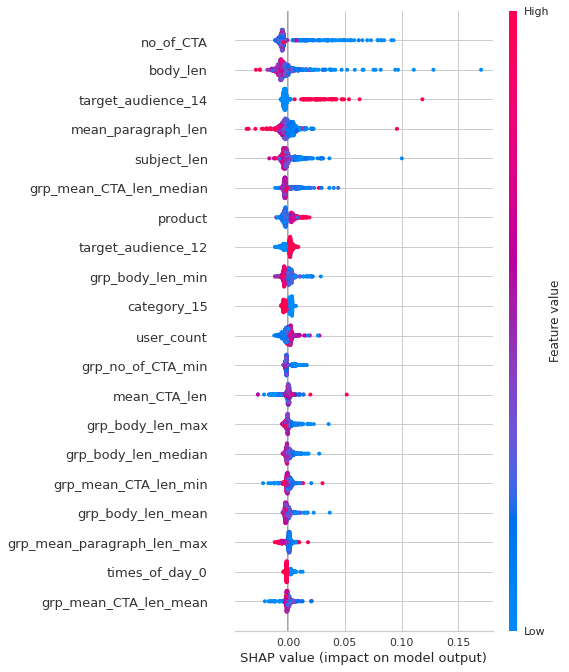

In [163]:
interpret_model(final.named_estimators_[list(final.named_estimators)[0]])


### Apply the pre-process steps to test dataset

In [145]:
test=pre_process(test)

### Predict the test data by using finalized blended model

In [146]:
test['click_rate']=(predict_model(final, data=test.loc[:,X.columns])['Label'])

### Create a result dataframe

In [147]:
res=pd.DataFrame({'campaign_id':test['campaign_id'],'click_rate':test['click_rate']})

### Write the result dataframe to csv

In [148]:
res.to_csv("pycaret_blend_final.csv",index=False)